## Miniconda installation

In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -u -p /usr/local

--2022-10-07 12:12:07--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2022-10-07 12:12:07--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76607678 (73M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  73.06M   255MB/s    in 0.3s    

2022-10-07 12:12:07 (255 MB/s) - ‘Miniconda3-latest-Linux

## MEEP installation

In [ ]:
import os
if os.path.isdir('/content/anaconda'): root_path = '/content/anaconda'
else: root_path = '/usr/local/'
os.environ['PATH'] += f":{root_path}/bin"
!conda create -n mp -c conda-forge pymeep python=3.7 -y
print(">> ", root_path)

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - done


==> WARNING: A newer version of conda exists. <==
  current version: 4.12.0
  latest version: 22.9.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /usr/local/envs/mp

  added / updated specs:
    - pymeep
    - python=3.7


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |            2_gnu          23 KB  conda-forge
    c-ares-1.18.1              |       h7f98852_0         113 KB  conda-forge
    ca-certificates-2022.9.24  |       ha878542_0         150 KB  conda-forge
    cached-property-1.5.2      |       hd8ed1ab_1           4 KB  conda-forge
    cached_property-1.5.2      |     pyha770c72_1  

In [ ]:
import sys
sys.path.append(f'{root_path}envs/mp/lib/python3.7/site-packages/')

## Simulation

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt



1. Define computational cell (simulation region)
2. Define materials
3. Define geometry
4. Define current sources
5. Boundary conditions
6. Define monitor fields
7. Create simulation objects



In [ ]:
resolution = 10 # 10 um/pixels which corresponds to around 67 pixels/wavelength, or around 20 pixels/wavelength in the high-index material

sx = 16  # size of cell in X direction
sy = 8   # size of cell in Y direction

pad = 4  # padding distance between waveguide and cell edge
w   = 1  # width of waveguide

dpml = 1.0

wvg_xcen =  0.5*(sx-w-2*pad)  # x center of horiz. wvg
wvg_ycen = -0.5*(sy-w-2*pad)  # y center of vert. wvg

# 0.15 corresponds to a vacuum wavelength of about 1/0.15=6.67 μm or ~2 μm for Si
# The current is located at (-7,0), which is 1 μm to the right of the left edge of the cell
fcen = 0.15  # pulse center frequency
df = 0.1     # pulse width (in frequency)
nfreq = 100  # number of frequencies at which to compute flux

### Simulation region

In [ ]:
cell = mp.Vector3(sx, sy, 0) # (x, y, z) size in um -> 16 um x 8 um (2D)

### Material

In [ ]:
from meep.materials import Si ## Problem!

### Geometry

In [ ]:
geometry = [mp.Block(size=mp.Vector3(mp.inf,w,mp.inf),
                     center=mp.Vector3(0,wvg_ycen,0),
                      material=mp.Medium(epsilon=12))]

### Current sources

In [ ]:
sources = [mp.Source(mp.ContinuousSource(fcen,fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(-0.5*sx+dpml,wvg_ycen,0),
                     size=mp.Vector3(0,w,0))]

# 0.15 corresponds to a vacuum wavelength of about 1/0.15=6.67 μm or ~2 μm for Si
# The current is located at (-7,0), which is 1 μm to the right of the left edge of the cell
#sources = [mp.Source(mp.ContinuousSource(frequency=0.15),
#                     component=mp.Ez,
#                     center=mp.Vector3(-7,0))]

### Boundary conditions

In [ ]:
## To add an absorbing layer of thickness 1 μm around all sides of the cell
pml_layers = [mp.PML(dpml)] ## PML layers on all axis
# pml_layers = [mp.PML(thickness=dpml,direction=mp.X)] ## PML layers on x axis

### Simulation objects

In [ ]:
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

In [ ]:
# reflected flux
refl_fr = mp.FluxRegion(center=mp.Vector3(-0.5*sx+dpml+0.5,wvg_ycen,0), size=mp.Vector3(0,2*w,0))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(center=mp.Vector3(0.5*sx-dpml,wvg_ycen,0), size=mp.Vector3(0,2*w,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

In [ ]:
pt = mp.Vector3(0.5 * sx - dpml - 0.5, wvg_ycen)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

# for normalization run, save flux fields data for reflection plane
straight_refl_data = sim.get_flux_data(refl)

# save incident power for transmission plane
straight_tran_flux = mp.get_fluxes(tran)

     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)


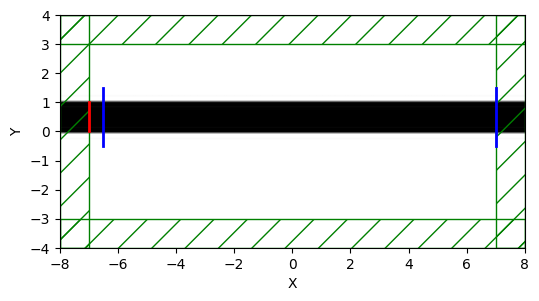

In [ ]:
f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

In [ ]:
sim.run(until=200)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00022912 s
Working in 2D dimensions.
Computational cell is 16 x 8 x 0 with resolution 10
     block, center = (0,0.5,0)
          size (1e+20,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
time for set_epsilon = 0.033576 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (4000 timesteps)


## Analyse results

### Dieletric

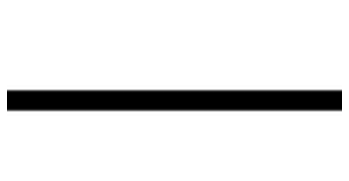

In [ ]:
eps_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Dielectric)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.axis('off')
plt.show()

### Ez field

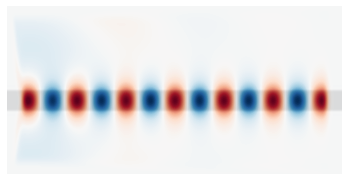

In [ ]:
ez_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ez)
plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()